# Multiclass Classification of Cultural Items
**Homework 1 - Multilingual Natural Language Processing**

*By Joshua Edwin & Clemens Kubach*

Add general project description here at the end.

## Installs
Check that all required dependencies are installed as defined in `pyproject.toml`. Follow the `README.md` for more detailed instructions.

## Machine Setup

### Imports

In [1]:
import pandas as pd
from datasets import DatasetDict, Dataset
import logging
import os


try:
    from google.colab import userdata  # type: ignore

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

logger = logging.getLogger(__name__)

from pathlib import Path

REPO_ROOT = Path(str(os.path.abspath(''))).parent.parent
DATA_DIR = REPO_ROOT / "data"
LOG_DIR = REPO_ROOT / "logs"
WANDB_DIR = REPO_ROOT / "wandb"

os.environ["WANDB_PROJECT"] = "mnlp-h1-lm"
os.environ["WANDB_DIR"] = str(WANDB_DIR)

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kubach to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Huggingface Login and Loading Data
To access the dataset, there are three options available that will be tried in the following fallback-order:


1.   From HF via HF_TOKEN secret/envvar if set.
2.   From HF via inserting the HF token manually in the login dialog.
3.   From local `./train.csv` and `./valid.csv` files.

Afterwards the hf dataset instance and train, val dataframes can be accessed via `hf_dataset`, `df_train` and `df_val`.

In [3]:
from os import environ

from datasets import load_dataset
from huggingface_hub import login
from datasets.exceptions import DatasetNotFoundError
from huggingface_hub.errors import HfHubHTTPError


def extract_dev_subsets_from_hf_dataset(
    ds: DatasetDict,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    _df_train = pd.DataFrame(ds["train"])  # Silver-labeled training set
    _df_validation = pd.DataFrame(ds["validation"])  # Gold-labeled dev set
    return _df_train, _df_validation


def read_hf_token() -> str | None:
    if IN_COLAB:
        try:
            return userdata.get("HF_TOKEN")
        except KeyError:
            return None
    else:
        return environ.get("HF_TOKEN", None)


def do_blocking_hf_login():
    # run the login in a separate cell because login is non-blocking
    try:
        token = read_hf_token()
        login(token=token)
        if token is None:
            # block until logged-in
            input("Press enter of finish login!")
    except (HfHubHTTPError, DatasetNotFoundError):
        print(
            "Login via HF_TOKEN secret/envvar and via manual login widget failed "
            "or not authorized."
        )


do_blocking_hf_login()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
def load_train_val_data() -> tuple[DatasetDict, pd.DataFrame, pd.DataFrame]:
    try:
        _ds = load_dataset("sapienzanlp/nlp2025_hw1_cultural_dataset")
        _df_train, _df_val = extract_dev_subsets_from_hf_dataset(_ds)
        return _ds, _df_train, _df_val
    except (HfHubHTTPError, DatasetNotFoundError) as e:
        logger.error(
            f"Something went wrong during HF dataset access: {e}. "
            "Falling back to local files:"
        )
    try:
        train_df = pd.read_csv("train.csv")
        valid_df = pd.read_csv("valid.csv")

        train_dataset = Dataset.from_pandas(train_df)
        valid_dataset = Dataset.from_pandas(valid_df)

        # Create a DatasetDict
        dataset_dict = DatasetDict(
            {"train": train_dataset, "validation": valid_dataset}
        )
        return dataset_dict, train_df, valid_df
    except FileNotFoundError:
        raise FileNotFoundError(
            "Tried to access the dataset from Huggingface "
            "(via HF_TOKEN secret/envvar and manual auth) and from the local disk"
            "(via train.csv and valid.csv in the cwd) without success."
        )


hf_dataset, df_train, df_val = load_train_val_data()

# Show samples
print("\nTrain Set:")
display(df_train.head())

print("\nValidation Set:")
display(df_val.head())


Train Set:


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive



Validation Set:


,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative


In [5]:
df_train["label"].unique()

array(['cultural exclusive', 'cultural representative',
       'cultural agnostic'], dtype=object)

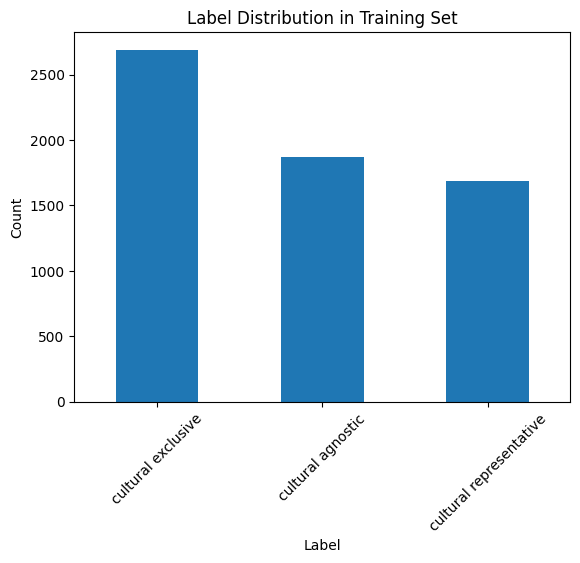

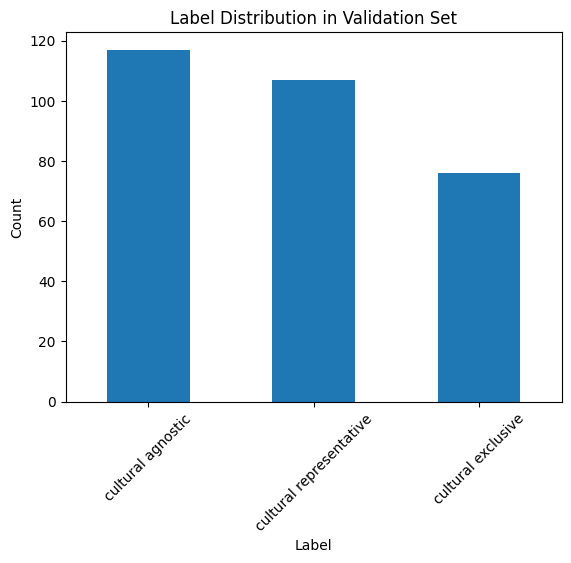

In [6]:
import matplotlib.pyplot as plt

def plot_label_distribution(df: pd.DataFrame, set_name: str):
    df["label"].value_counts().plot(kind="bar")
    plt.title(f"Label Distribution in {set_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

plot_label_distribution(df_train, set_name="Training Set")
plot_label_distribution(df_val, set_name="Validation Set")

In [7]:
print("HF dataset instance keys:", list(hf_dataset.keys()))
print("Train columns:", list(df_train.columns))
print("Val columns:", list(df_val.columns))

HF dataset instance keys: ['train', 'validation']
Train columns: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label']
Val columns: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label']


## LM-based Approach

Methodology: Use different pretrained language models that are based on transformer architectures. For this, we will use the Huggingface Transformers library.

We will use the following models:
- BERT
- BERT Multilingual
- GEMMA 3 (Mutlilingual) - requires implementation for sequence classification task

For each model, adjust the hyperparameters and training settings to mitigate overfitting and improve the performance of the model.

The models will be trained on the training set and evaluated on the validation set. The results will be logged to Weights & Biases (wandb) for further analysis.

In [8]:
# MODEL_NAME = "distilbert/distilbert-base-cased"
MODEL_NAME = "bert-base-multilingual-cased"
# MODEL_NAME = "facebook/xlm-roberta-xl" # too large for gpu
# MODEL_NAME = "FacebookAI/xlm-roberta-base"
# MODEL_NAME = "FacebookAI/xlm-roberta-large" # too large for gpu

In [9]:
from enum import IntEnum


class Labels(IntEnum):
    cultural_agnostic = 0
    cultural_representative = 1
    cultural_exclusive = 2

LABEL2ID = {
    "cultural agnostic": 0,
    "cultural representative": 1,
    "cultural exclusive": 2,
}
ID2LABEL = {k: v for v, k in LABEL2ID.items()}

In [10]:
from transformers import PreTrainedTokenizer, AutoTokenizer, DataCollatorWithPadding


class PreProcessor:

    def __init__(
            self,
            tokenizer_name: str,
            agg_in_fields: tuple[str, ...] = ("name", "description"),
    ):
        self.tokenizer_name = tokenizer_name
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

        self.agg_in_fields = agg_in_fields

    def __call__(self, samples):
        return self.preprocess_function(samples, self.tokenizer, self.agg_in_fields)

    @staticmethod
    def preprocess_function(
            samples,
            tokenizer: PreTrainedTokenizer,
            agg_in_fields: tuple[str, ...] = ("name", "category", "type", "subcategory", "description"),
    ):
        """Aggregate and tokenize input fields and one-hot encode labels."""
        to_tokenize = [samples[col] for col in agg_in_fields]
        input_samples = tokenizer(*to_tokenize, truncation=True, padding=True)
        input_samples["labels"] = [LABEL2ID[label] for label in samples["label"]]
        return input_samples

preprocessor = PreProcessor(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=preprocessor.tokenizer)
preprocessed_hf_dataset = hf_dataset.map(preprocessor, batched=True)
required_columns = preprocessor.tokenizer.model_input_names + ['labels']
preprocessed_hf_dataset.set_format(type='torch', columns=required_columns)

preprocessed_hf_dataset


Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6251
    })
    validation: Dataset({
        features: ['item', 'name', 'description', 'type', 'category', 'subcategory', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 300
    })
})

In [11]:
import evaluate
import numpy as np


class Evaluator:

    def __init__(self):
        self.accuracy = evaluate.load("accuracy")
        self.f1 = evaluate.load("f1")
        self.precision = evaluate.load("precision")
        self.recall = evaluate.load("recall")

    def __call__(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy_results = self.accuracy.compute(predictions=predictions, references=labels)
        f1_results = self.f1.compute(predictions=predictions, references=labels, average="weighted")
        precision_results = self.precision.compute(predictions=predictions, references=labels, average="weighted")
        recall_results = self.recall.compute(predictions=predictions, references=labels, average="weighted")
        # combine results to one dict
        results = {**accuracy_results, **f1_results, **precision_results, **recall_results}
        return results


evaluator = Evaluator()

In [12]:
from collections import Counter
from transformers.integrations import WandbCallback



def decode_predictions(model, predictions):
    id2label = model.config.id2label
    labels = [id2label[i] for i in predictions.label_ids]
    logits = predictions.predictions.argmax(axis=-1)
    prediction_text = [id2label[i] for i in logits]
    return {"labels": labels, "predictions": prediction_text}


class CustomWandbCallback(WandbCallback):

    def __init__(self, trainer, tokenizer, sample_dataset: Dataset):
        super().__init__()
        self.trainer = trainer
        self.tokenizer = tokenizer
        self.sample_dataset = sample_dataset

    def on_evaluate(self, args, state, control, **kwargs):
        super().on_evaluate(args, state, control, **kwargs)
        predictions = self.trainer.predict(self.sample_dataset)

        predicted_class_ids = predictions.predictions.argmax(axis=-1)
        del predictions
        # Optionally decode to class names
        id2label = self.trainer.model.config.id2label
        predicted_labels = [id2label[i] for i in predicted_class_ids]

        # self._wandb.log({"eval/predicted_class_distribution": wandb.Histogram(predicted_class_ids)}, step=state.global_step)
        label_counts = Counter(predicted_labels)
        label_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).reset_index()
        label_df.columns = ['label', 'count']

        self._wandb.log({
            "eval/predicted_class_distribution": wandb.plot.bar(
                wandb.Table(dataframe=label_df),
                "label", "count",
                title="Predicted Class Distribution"
            )
        }, step=state.global_step)

In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, label2id=LABEL2ID, id2label=ID2LABEL, classifier_dropout=0.4 #, load_in_16bit=True,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import Adafactor

wandb.finish()
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
unique_run_name = f"{MODEL_NAME}-{timestamp}"

training_args = TrainingArguments(
    output_dir=LOG_DIR / MODEL_NAME,
    learning_rate=5e-6,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    logging_steps=10,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to="wandb",
    run_name=unique_run_name,
    gradient_accumulation_steps=16,
    gradient_checkpointing=True,
    fp16=True,
)

optimizer = Adafactor(
    model.parameters(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=preprocessed_hf_dataset["train"],
    eval_dataset=preprocessed_hf_dataset["validation"],
    processing_class=preprocessor.tokenizer,
    data_collator=data_collator,
    compute_metrics=evaluator,
    optimizers=(optimizer, None),
)
trainer.add_callback(
    CustomWandbCallback(trainer, preprocessor.tokenizer, preprocessed_hf_dataset["validation"])
)

trainer.train()
wandb.finish()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677500,0.694506,0.653333,0.616078,0.674020,0.653333
2,0.542900,0.616144,0.720000,0.714385,0.727599,0.720000
3,0.469900,0.582032,0.743333,0.735584,0.741399,0.743333
4,0.443800,0.558875,0.783333,0.779532,0.781309,0.783333
5,0.370700,0.583323,0.783333,0.778891,0.785023,0.783333
6,0.363900,0.557636,0.793333,0.789824,0.788760,0.793333
7,0.416300,0.574456,0.793333,0.789114,0.790154,0.793333
8,0.321700,0.587097,0.796667,0.792802,0.794712,0.796667
9,0.324700,0.592816,0.803333,0.799779,0.799915,0.803333
10,0.325200,0.592027,0.803333,0.800086,0.800365,0.803333


eval/accuracy,▁▁▄▄▅▅▇▇▇▇██████████
eval/f1,▁▁▅▅▆▆▇▇▇▇██████████
eval/loss,██▄▄▂▂▁▁▂▂▁▁▂▂▃▃▃▃▃▃
eval/precision,▁▁▄▄▅▅▇▇▇▇▇▇▇▇██████
eval/recall,▁▁▄▄▅▅▇▇▇▇██████████
eval/runtime,▇▇████▇▇▂▂▇▇██▇▇██▁▁
eval/samples_per_second,▂▂▁▁▁▁▂▂▇▇▂▂▁▁▂▂▁▁██
eval/steps_per_second,▂▂▁▁▁▁▂▂▇▇▂▂▁▁▂▂▁▁██
test/accuracy,▁▁▄▄▅▅▇▇▇▇██████████
test/f1,▁▁▅▅▆▆▇▇▇▇██████████
test/loss,██▄▄▂▂▁▁▂▂▁▁▂▂▃▃▃▃▃▃
